In [1]:
import numpy as np
import matplotlib.pyplot as plt
from esn import ESN

In [2]:
# 心電図波形(ECG)データの読み込み
def read_ecg_data(file_name):
    data = np.empty(0)
    count = 0
    with open(file_name, 'r') as f:
        lines = f.readlines()
        for line in lines:
            tmp = line.split()
            if count >= 2:  # ヘッダ削除
                data = np.hstack((data, float(tmp[1])))  # ECG1[mV]
            count = count + 1
    return data

In [3]:
# 訓練データ、検証データ
normal = read_ecg_data(file_name='data/normal.txt')
anomaly = read_ecg_data(file_name='data/anomaly.txt')    

# 訓練、検証データ
unit_sample = 128  # 1secあたりのサンプル数
T_start = 1*unit_sample
T_middle1 = 29*unit_sample
T_middle2 = 31*unit_sample
T_end = 59*unit_sample

train_X = normal[T_start:T_middle1].reshape(-1, 1)
train_Y = normal[T_start+1:T_middle1+1].reshape(-1, 1)

test_anomaly_X = anomaly[T_start:T_end].reshape(-1, 1)
test_anomaly_Y = anomaly[T_start+1:T_end+1].reshape(-1, 1)

test_normal_X = normal[T_middle2:T_end].reshape(-1, 1)
test_normal_Y = normal[T_middle2+1:T_end+1].reshape(-1, 1)

In [4]:
# 入力層
N_u = 1
N_x = 500
input_scale = 1
rec_scale = 1.0
rho = 0.9
leaking_rate = 1
activation_func = np.tanh
seed = 0

# ESNのインスタンスを作成
esn = ESN(N_u, N_x, input_scale, rec_scale, rho, leaking_rate, activation_func, seed)

In [5]:
# リザバー状態の計算（学習データ）
stateCollectMat_train = esn.compute_reservoir_states(train_X)

# 学習（リードアウト重みの計算）
Wout = esn.train(stateCollectMat_train, train_Y)
Y_pred_train = esn.predict(Wout, stateCollectMat_train).T   

# テストデータでの予測
stateCollectMat_test_anomaly = esn.compute_reservoir_states(test_anomaly_X)
Y_pred_test_anomaly = esn.predict(Wout, stateCollectMat_test_anomaly).T
stateCollectMat_test_normal = esn.compute_reservoir_states(test_normal_X)
Y_pred_test_normal = esn.predict(Wout, stateCollectMat_test_normal).T

# 誤差計算
error_train = abs(Y_pred_train - train_Y)
error_test_anomaly = abs(Y_pred_test_anomaly - test_anomaly_Y)
error_test_normal = abs(Y_pred_test_normal - test_normal_Y)

Computing Reservoir States: 100%|█████████████████████████████| 3584/3584 [00:00<00:00, 4408.28it/s]


<Figure size 700x500 with 0 Axes>

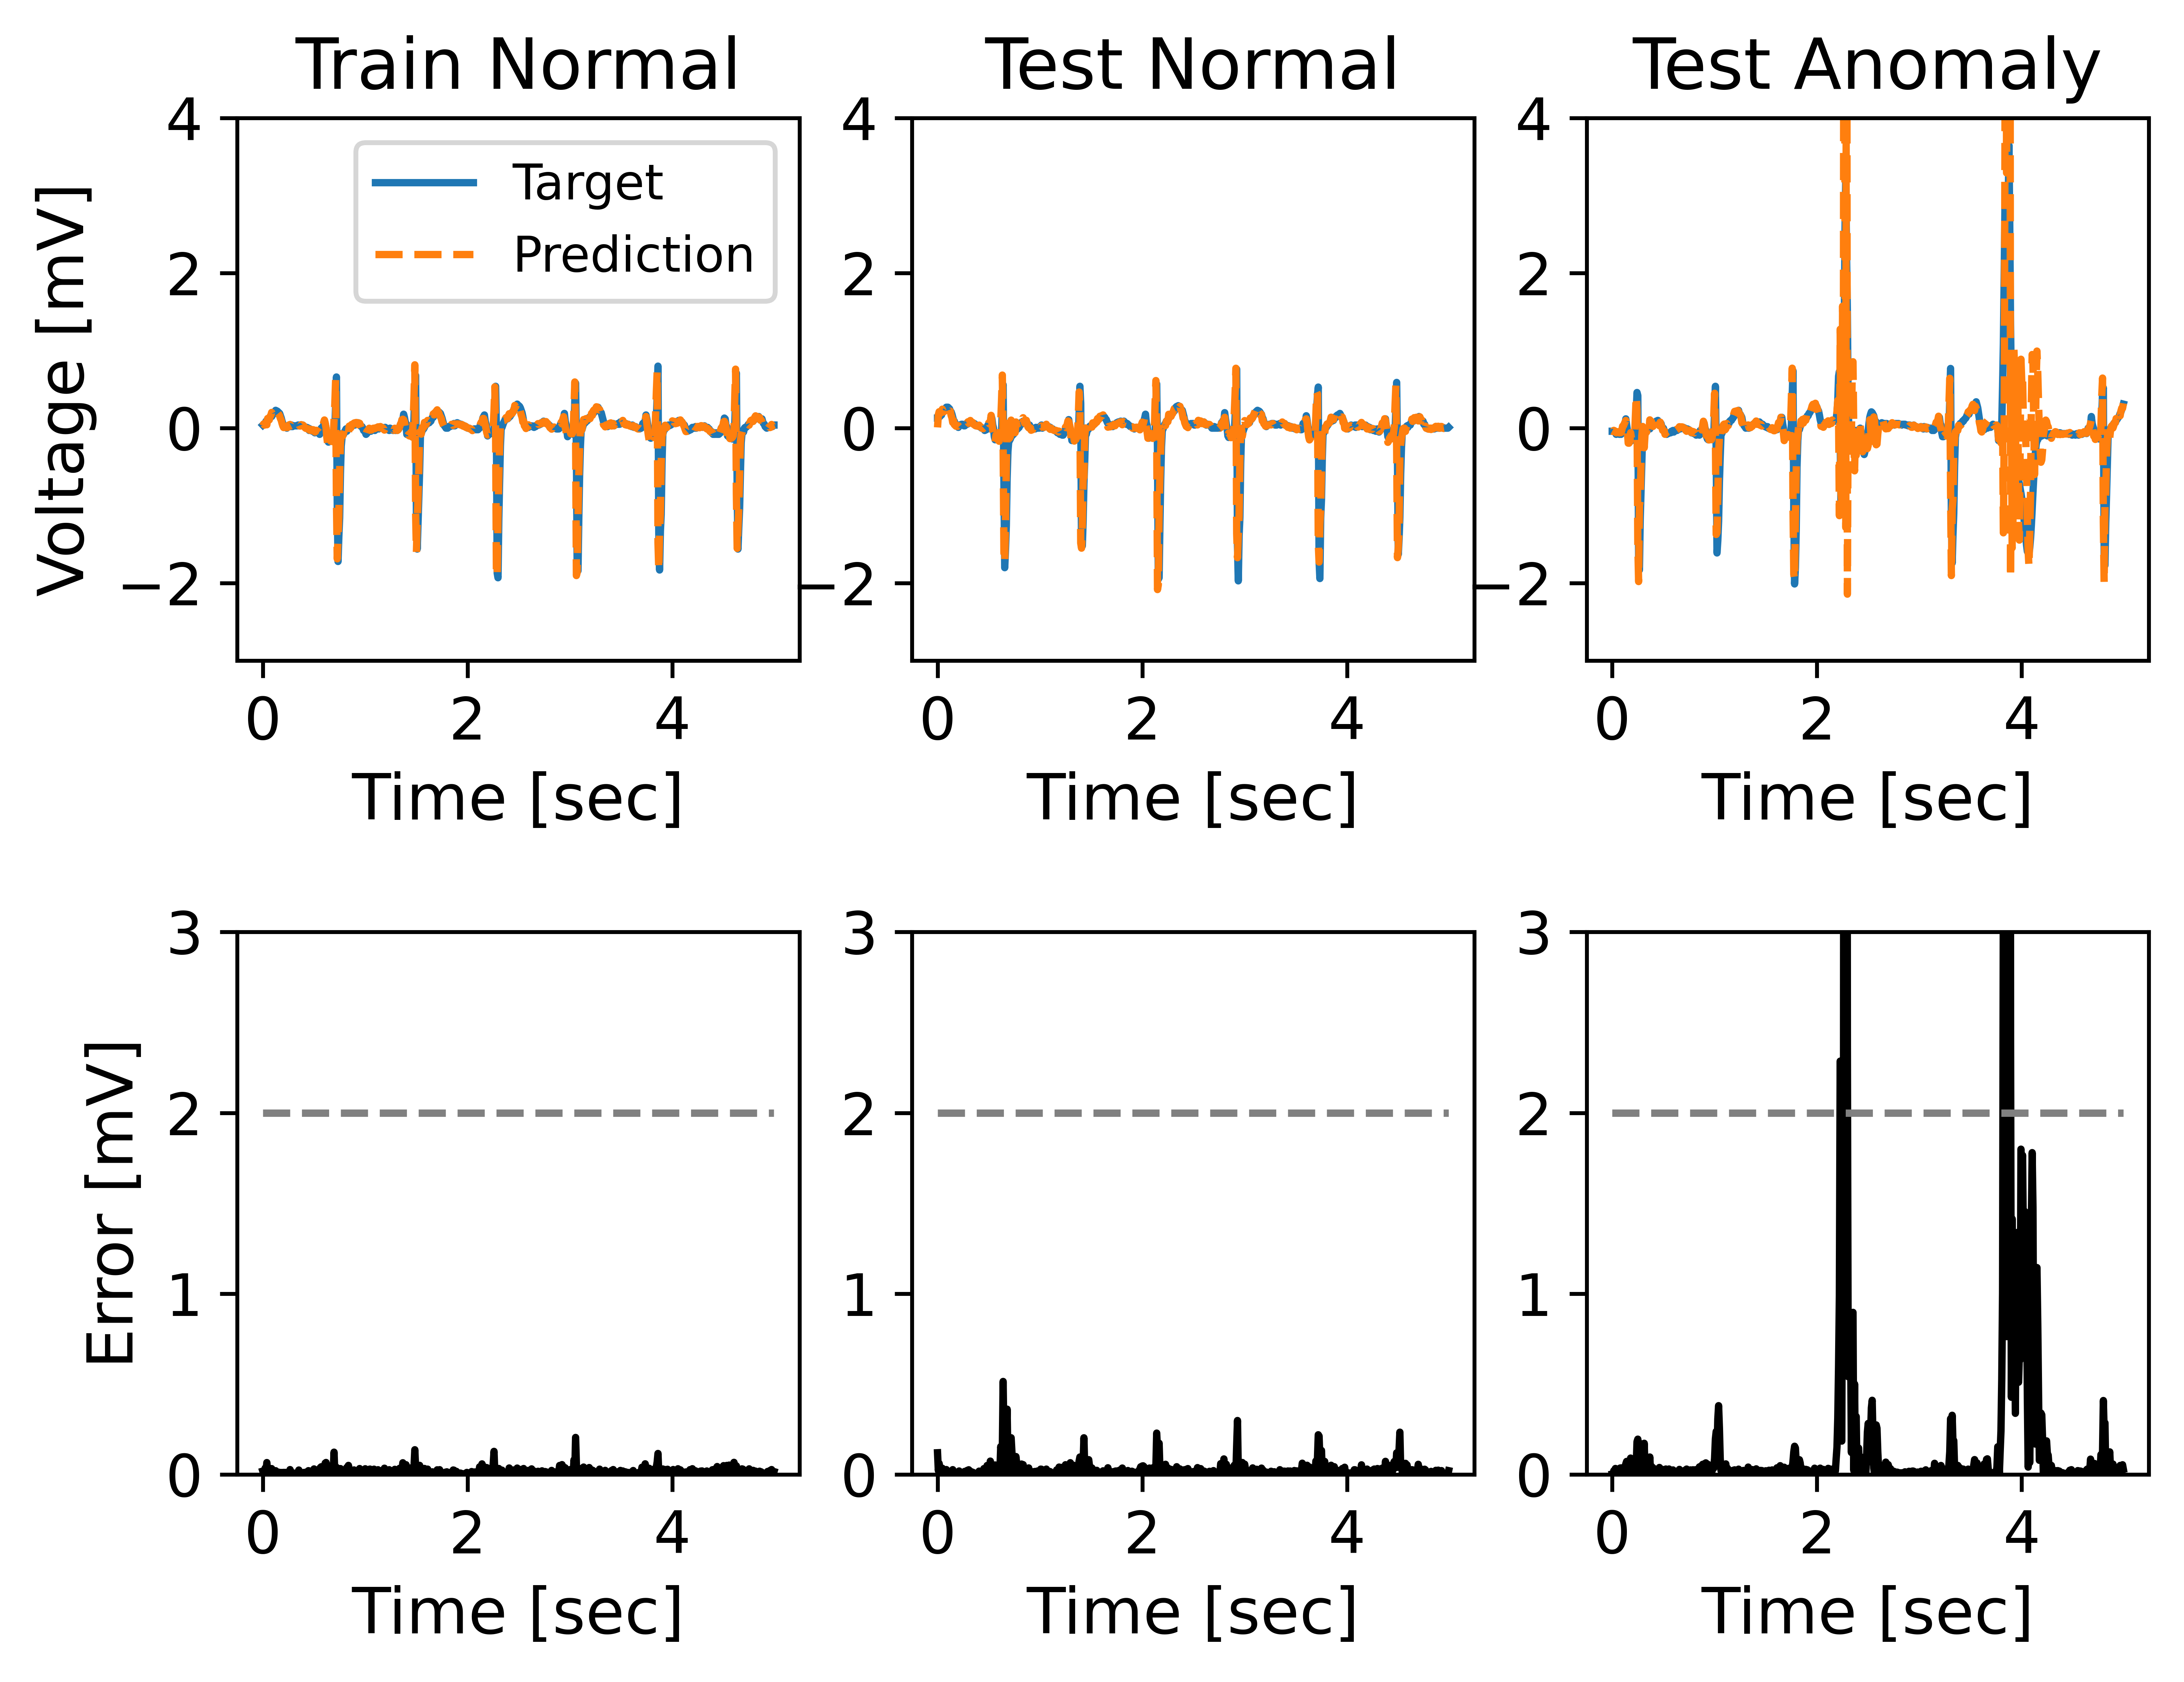

In [6]:
# グラフ表示
plt.rcParams["font.size"] = 12
fig = plt.figure(figsize=(7, 5))
plt.subplots_adjust(hspace=0.5)

# 時間
t = np.linspace(0, 60, 7680)

# グラフ表示
plt.rcParams["font.size"] = 12
fig = plt.figure(figsize=(7, 5), dpi=1000)
plt.subplots_adjust(hspace=0.5)

ax1 = fig.add_subplot(2, 3, 1)
plt.plot(t[0*128:5*128], normal[15*128:20*128], label='Target')
plt.plot(t[0*128:5*128], Y_pred_train[14*128:19*128], linestyle='--', label='Prediction')
plt.ylim([-3,4])
plt.title('Train Normal')
plt.xlabel("Time [sec]", fontsize=13)
plt.ylabel("Voltage [mV]", fontsize=13)
plt.legend(fontsize=10)

ax2 = fig.add_subplot(2, 3, 2)
plt.plot(t[0*128:5*128], normal[40*128:45*128])
plt.plot(t[0*128:5*128], Y_pred_test_normal[9*128:14*128], linestyle='--')
plt.ylim([-3,4])
plt.title('Test Normal')
plt.xlabel("Time [sec]", fontsize=13)

ax3 = fig.add_subplot(2, 3, 3)
plt.plot(t[0*128:5*128], anomaly[20*128:25*128])
plt.plot(t[0*128:5*128], Y_pred_test_anomaly[19*128:24*128], linestyle='--')
plt.ylim([-3,4])
plt.title('Test Anomaly')
plt.xlabel("Time [sec]", fontsize=13)

ax4 = fig.add_subplot(2, 3, 4)
plt.plot(t[0*128:5*128], error_train[14*128:19*128], color='k')
plt.ylim([0,3])
plt.xlabel("Time [sec]", fontsize=13)
plt.ylabel("Error [mV]", fontsize=13)
plt.hlines(2, xmin=t[0*128], xmax=t[5*128-1], colors="gray", linestyles='dashed')  

ax5 = fig.add_subplot(2, 3, 5)
plt.plot(t[0*128:5*128], error_test_normal[9*128:14*128], color='k')
plt.ylim([0,3])
plt.xlabel("Time [sec]", fontsize=13)
plt.hlines(2, xmin=t[0*128], xmax=t[5*128-1], colors="gray", linestyles='dashed')  

ax6 = fig.add_subplot(2, 3, 6)
plt.plot(t[0*128:5*128], error_test_anomaly[19*128:24*128], color='k')
plt.ylim([0,3])
plt.xlabel("Time [sec]", fontsize=13)
plt.hlines(2, xmin=t[0*128], xmax=t[5*128-1], colors="gray", linestyles='dashed')  

plt.show()